In [7]:
import os, sys, glob
import matplotlib.pyplot as plt
import numpy as np
import pyart
import math
import cartopy.crs as ccrs
import cartopy
import warnings
warnings.filterwarnings("ignore")

from scipy.special import gamma

###############################################################################################
# Function to retrieve PolZR rain rate
# Will be added to GVRadar
# March 2023 - Jason Pippitt
###############################################################################################

if __name__ == "__main__":
    
    #site = 'PHKI'
    #site = 'KMQT'
    site = 'NPOL'
    BASE_DIR = '/Users/jpippitt/GPM-GV/'
    
    # Grab legacy QC file
    if(site == 'KMQT'):
        file = f"{BASE_DIR}/KMQT_2022_1130_015759.cf"
    if(site == 'PHKI'):
        file = f"{BASE_DIR}/PHKI_2019_1206_122918.cf"
    if(site == 'NPOL'):
        file = "/Users/jpippitt/GPM-GV/GVradar/notebooks/cf/2022/1127/NPOL_2022_1127_195529_PPI.cf"
    
    print(f"<-- {file}")
    radar = pyart.io.read(file, file_field_names=True)
    print(' ','Input Fields:',radar.fields.keys(),sep='\n')
    
    dbz = radar.fields['CZ']['data']
    zdr = radar.fields['DR']['data']
    kdp = radar.fields['KD']['data']
    rhv = radar.fields['RH']['data']
    nw = radar.fields['NW']['data']
    hid = radar.fields['FS']['data']
    
    rp = np.ma.zeros(dbz.shape)
    
    rp, nw = get_bringi_rainrate_nw(dbz,zdr,kdp,rhv,nw,hid)

    # Adding this field into the radar object using radar.add_field()
    rp_dict = {'data': rp, 'units': 'mm/hr', 'long_name': 'Polzr_Rain_Rate',
             '_FillValue': 0.0, 'standard_name': 'Polzr_Rain_Rate_Ali_nw'}
    radar.add_field('RP1', rp_dict, replace_existing=True)
    
    rp, nw = get_bringi_rainrate(dbz,zdr,kdp,rhv,hid)
    
    rp_dict = {'data': rp, 'units': 'mm/hr', 'long_name': 'Polzr_Rain_Rate',
             '_FillValue': 0.0, 'standard_name': 'Polzr_Rain_Rate_Computed_nw'}
    radar.add_field('RP2', rp_dict, replace_existing=True)
    nw_dict = {'data': nw, 'units': 'Log[Nw, m^-3 mm^-1]', 'long_name': 'Polzr_NW',
             '_FillValue': 0.0, 'standard_name': 'Polzr_NW'}
    radar.add_field('PW', nw_dict, replace_existing=True)
    
    print("Done.")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

<-- /Users/jpippitt/GPM-GV/GVradar/notebooks/cf/2022/1127/NPOL_2022_1127_195529_PPI.cf
 
Input Fields:
dict_keys(['DZ', 'VR', 'DR', 'KD', 'PH', 'RH', 'CZ', 'SD', 'DM', 'NW', 'FS', 'RC'])
Done.


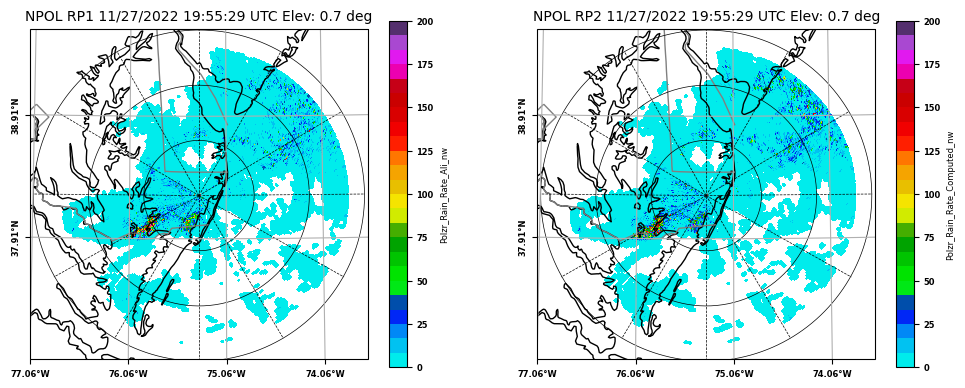

In [8]:
# Plot rain rate fields
lim = [-150, 150]
two_panel_plot(radar, sweep=0, var1='RP1', vmin1=0, vmax1=200,
               cmap1=discrete_cmap(24,'pyart_NWSRef'), var2='RP2', vmin2=0, vmax2=200, 
               cmap2=discrete_cmap(24,'pyart_NWSRef'), units2='Polzr_Rain_Rate_Computed_nw', return_flag=False, 
               xlim=lim, ylim=lim, units1='Polzr_Rain_Rate_Ali_nw')

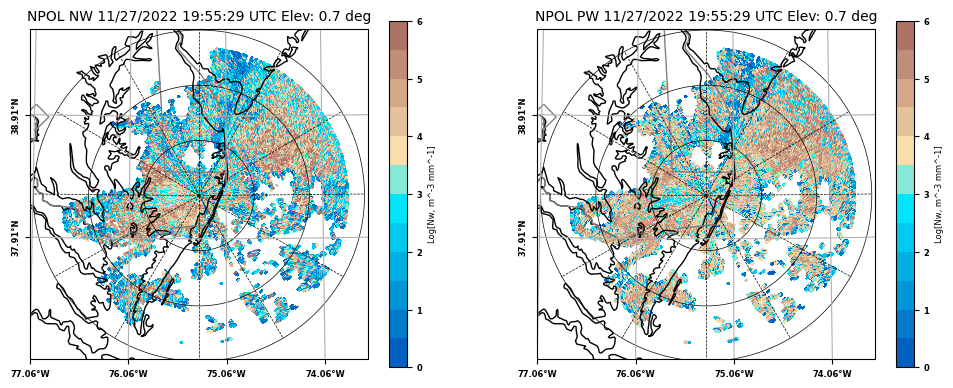

In [9]:
# Plot DSD fields
two_panel_plot(radar, sweep=0, var1='NW', vmin1=0, vmax1=6,
               cmap1=discrete_cmap(12, 'pyart_BlueBrown10'), var2='PW', vmin2=0, vmax2=6, 
               cmap2=discrete_cmap(12, 'pyart_BlueBrown10'), units2='Log[Nw, m^-3 mm^-1]', return_flag=False, 
               xlim=lim, ylim=lim, units1='Log[Nw, m^-3 mm^-1]')

In [1]:
def get_bringi_rainrate(dbz,zdr,kdp,rhv,hid):

    #Calculates DSD fields to assign a rain rate.  

    #Disdrometer-based Z-R coefficients
    #a1 = 0.024285, b1 = 0.6895, Z = 219 Z^1.45
    #a1 = 0.017, b1 = 0.7143, Z = 300 Z^1.4 
    #a1 = 0.036. b1 = 0.6250, Z = 200 R^1.6 
    #a_dsd = (1.0/a1)**(1./b1)
    #b_dsd = (1.0/b1)

    #Check to see if DP variables can be used to calculate 
    #the rain rate. We need D0, Nw and mu to calculate the 
    #Polarimetric ZR

    zh = 10.**(0.1*dbz)     
    xi_dr = 10.**(0.1*zdr)
    d0 = np.zeros(dbz.shape)
    dm = np.zeros(dbz.shape)
    nw = np.zeros(dbz.shape)
    logNw = np.zeros(dbz.shape)
    mu = np.ones(dbz.shape) * 3.0
    beta = 0

    # Light rain rates with noisy Zd
    light_rain = np.logical_and(zdr >= -0.5, zdr < 0.2)
    nw[light_rain] = get_nw_light(zh[light_rain],xi_dr[light_rain])
    
    # Light rain rates with modest kdp
    modest_kdp = np.logical_and(kdp < 0.3, zdr >= 0.2, zdr < 0.5)
    nw[modest_kdp] = get_nw_modest(zdr[modest_kdp],zh[modest_kdp],xi_dr[modest_kdp])
    
    # Moderate rain rates
    moderate_rr = np.logical_and(kdp < 0.3, zdr >= 0.5)
    nw[moderate_rr] = get_moderate_nw(zdr[moderate_rr],zh[moderate_rr])
    
    # Heavy rain rates
    heavy_rr = np.logical_and(dbz >= 35, kdp >= 0.3, zdr >= 0.2)
    nw[heavy_rr], mu[heavy_rr] = get_heavy_nw(zdr[heavy_rr],kdp[heavy_rr],zh[heavy_rr],xi_dr[heavy_rr])
           
    # Calculate the coefficient a' in Z = a' * R^1.5 using the DSD
    # parameters. First, calculate f(mu)
    mu = 3.0
    rp = get_polzr_rainrate(dbz,nw,mu)
    
    # Max rain rate test
    rr_max = np.greater(rp,300)
    rp[rr_max] = rp[rr_max] * -1.0
    
    # HID ice threshold
    hid_ice = [0, 3, 4, 5, 6, 7, 8, 9]
    for xice in hid_ice:
        ice = np.equal(hid, xice)
        rp[ice] = -999
    
    # Check if Rain rate is not finite!
    rr_inf = np.isinf(rp)
    rp[rr_inf] = rp[rr_inf] * -1.0    
    
    nw = np.log10(nw)
    
    return rp, nw

In [2]:
def get_polzr_rainrate(dbz,nw,mu):
    
    # From eq. A.25 in Bring et al. 2004
    x1 = 6.0 * (3.67 + mu)**(4+mu)
    x2 = (3.67**4) * gamma(mu+4)
    f_mu = x1/x2

    # From eq. A.23 in Bring et al. 2004
    x3 = f_mu * gamma(7+mu)
    x4 = (3.67+mu)**(7+mu)
    fz_mu = x3/x4

    # From eq. A.24 in Bring et al. 2004
    x5  = np.pi * 0.0006 * 3.78 * f_mu
    x6  = gamma(4.67 + mu) / (3.67+mu)**(4.67+mu)

    fr_mu = x5 * x6
    
    a_mu = fz_mu / (fr_mu**(1.5))

    # Now, the new A parameter for the Z-R relation is given by:
    # a' = a_mu/(nw^1.5) 

    a_prime = a_mu/(nw**0.5)
    b = 1.5
    rp =  get_zr_rain(dbz, a_prime, b)

    return rp

In [3]:
def get_zr_rain(dbz, a, b):
    
    # Set max_dbz dB as maximum reasonable reflectivity
    max_dbz = 55
    dbz_max = np.greater_equal(dbz,max_dbz)
    dbz[dbz_max] = max_dbz

    # Now calculate the rain rate from the pass dBZ value
    zh = 10**(dbz/10.0)
    rp = (zh/a)**(1.0/1.5)
    #x1 = 0.1*(dbz - 10*np.log10(a))/b
    #rp = 10**(x1)
    
    return rp

In [4]:
def get_nw_light(zh,xi_dr):

    d0 = 0.6096*(zh**0.0516)*(xi_dr**3.111)
    nw = (21*zh)/d0**7.3529
    mu = 3.0
    dm = d0 * ((4+mu)/(3.67+mu))
    
    return nw

def get_nw_modest(zdr,zh,xi_dr):

    x1 = ((zdr - 0.2)/0.3) * 1.81 * zdr**(0.486)
    x2 = ((0.5-zdr)/0.3) * 0.6096*zh**(0.0516) * xi_dr**(3.111)
    d0 = x1 + x2
    nw = (21*zh)/d0**7.3529
    mu = 3.0
    dm = d0 * ((4+mu)/(3.67+mu))
    
    return nw

def get_moderate_nw(zdr,zh):

    d0 = 1.81*zdr**0.486
    nw = (21*zh)/d0**7.3529
    mu = 3.0
    dm = d0 * ((4+mu)/(3.67+mu))
    
    return nw

def get_heavy_nw(zdr,kdp,zh,xi_dr):
    beta = 2.08*zh**(-0.365) * kdp**(0.38) * xi_dr**(0.965)
    a1 = 0.56
    b1 = 0.064
    c1 = 0.024*beta**(-1.42)
    d0 = a1 * zh**b1 * xi_dr**c1
    a2 = 3.29
    b2 = 0.058
    c2 = -0.023 * beta**(-1.389)
    logNw = a2 * zh**b2 * xi_dr**c2
    nw = 10**(logNw)
    a3 = 203. * beta**(1.89)
    b3 = 2.23 * beta**(0.0388)
    c3 = 3.16 * beta**(-0.0463)
    d3 = 0.374 * beta**(-0.355)
    x1 = a3 * (d0**b3)/(xi_dr-1)
    x2 = c3 * (xi_dr**d3)
    mu = x1 - x2
    dm = d0 * ((4+mu)/(3.67+mu))    
    
    return nw, mu

In [5]:
def get_bringi_rainrate_nw(dbz,zdr,kdp,rhv,nw,hid):

    # Calculate the coefficient a' in Z = a' * R^1.5 using the DSD
    # parameters. First, calculate f(mu)
    mu = 3.0
    nw = 10**nw
    rp = get_polzr_rainrate(dbz,nw,mu)
    
    # Max rain rate test
    rr_max = np.greater(rp,300)
    rp[rr_max] = rp[rr_max] * -1.0

    # HID ice threshold
    hid_ice = [0, 3, 4, 5, 6, 7, 8, 9]
    for xice in hid_ice:
        ice = np.equal(hid, xice)
        rp[ice] = -999
    
    # Check if Rain rate is not finite!
    rr_inf = np.isinf(rp)
    rp[rr_inf] = rp[rr_inf] * -1.0
    
    nw = np.log10(nw)
    return rp, nw

In [6]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

def extract_unmasked_data(radar, field, bad=-32767.0):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def add_field_to_radar_object(field, radar, field_name='UN', units='',
                              long_name='UNKNOWN', standard_name='UNKNOWN',
                              dz_field='CZ'):
    #fill_value = 0
    fill_value = -32767.0
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value,
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask',
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def two_panel_plot(radar, sweep=0, var1='reflectivity', title1 = ' ', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity', title2 = ' ',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    
    site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep = get_radar_info(radar, sweep)
    title1 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var1,mydate,mytime,elv)
    title2 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var2,mydate,mytime,elv)
    
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = xlim[1] * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    min_lat = radar_lat - maxrange_meters * meters_to_lat
    max_lat = radar_lat + maxrange_meters * meters_to_lat
    min_lon = radar_lon - maxrange_meters * meters_to_lon
    max_lon = radar_lon + maxrange_meters * meters_to_lon
    min_lon_rn=round(min_lon,2)
    max_lon_rn=round(max_lon,2)
    min_lat_rn=round(min_lat,2)
    max_lat_rn=round(max_lat,2)
    lon_grid = np.arange(min_lon_rn - 1.00 , max_lon_rn + 1.00, 1.0)
    lat_grid = np.arange(min_lat_rn - 1.00 , max_lat_rn + 1.00, 1.0)
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    projection = ccrs.LambertConformal(radar_lon, radar_lat)
    display = pyart.graph.RadarMapDisplay(radar)
    fig = plt.figure(figsize=(12,4.5))
    
    ax1 = fig.add_subplot(121,projection=projection)
    display.plot_ppi_map(var1, sweep, vmin=vmin1, vmax=vmax1,
                     resolution='10m',
                     title = title1,
                     projection=projection, ax=ax1,
                     cmap=cmap1,
                     colorbar_label=units1,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax2 = fig.add_subplot(122,projection=projection)
    display.plot_ppi_map(var2, sweep, vmin=vmin2, vmax=vmax2,
                     resolution='10m',
                     title = title2,
                     projection=projection, ax=ax2,
                     cmap=cmap2,
                     colorbar_label=units2,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    if return_flag:
        return fig, ax1, ax2, display

def add_radials(radar,display,max_range):

    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))
    
    for azi in range(0,360,30):
        azimuth = 90. - azi
        dazimuth = azimuth * dtor
        lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
        lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
        display.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange],
                              line_style='k--',lw=0.5)

def get_radar_info(radar, sweep):
    #
    # *** get radar elevation, date, time
    #
    radar_DT = pyart.util.datetime_from_radar(radar)
    elv=radar.fixed_angle['data'][sweep]
    string_csweep = str(sweep).zfill(2)
    month = str(radar_DT.month).zfill(2)
    day = str(radar_DT.day).zfill(2)
    year = str(radar_DT.year).zfill(4)
    hh = str(radar_DT.hour).zfill(2)
    mm = str(radar_DT.minute).zfill(2)
    ss = str(radar_DT.second).zfill(2)
    mydate = month + '/' + day + '/' + year
    mytime = hh + ':' + mm + ':' + ss
    if 'site_name' in radar.metadata.keys():
        site = radar.metadata['site_name'].upper()
    elif 'instrument_name' in radar.metadata.keys():
        if isinstance(radar.metadata['instrument_name'], bytes):
            site = radar.metadata['instrument_name'].decode().upper()
        else:
            site = radar.metadata['instrument_name'].upper()
    else:
        site=''

    return site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep    
    
def adjust_fhc_colorbar_for_pyart(cb,type='summer'):
    if type == 'summer':
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                               'Wet Snow', 'Vertical Ice', 'LD Graupel',
                               'HD Graupel', 'Hail', 'Big Drops'])
    if type == 'winter':
        cb.set_ticks(np.arange(1.4, 7, 0.9))
        cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain'])

    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)

    return cb

def dbz_to_zlin(dz):
    """
    Convert from log [dBZ] to linear Z [mm^6 m^−3] units.
    Parameters
    ----------
    dbz : float or array
        logarithmic reflectivity value
    """
    return 10.**(np.asarray(dz)/10.)

def zlin_to_dbz(Z):
    """
    Convert from linear Z [mm^6 m^−3] to log [dBZ] units.
    Parameters
    ----------
    zlin : float or array
        linear reflectivity units
    """
    return 10. * np.log10(np.asarray(zlin))